# This is a work in progress
It hasn't converged down as much as I like. The lowest MSE I have pulled off so far on the Test data is 0.005.

One idea is to also train on the CIFAR-100 dataset. But currently I'm not sure if CIFAR-100 contains any of the test images in CIFAR-10.

## Imports

In [1]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import time

(X_orig, _), (X_test, _) = cifar10.load_data()
X_orig = X_orig / 255.0
X_test = X_test / 255.0

numOrig = X_orig.shape[0]
numTest = X_test.shape[0]

validIdx = int(numOrig * 0.1)
X_valid = np.copy(X_orig[:validIdx, :, :])
X_train = np.copy(X_orig[validIdx:, :, :])
numValid = X_valid.shape[0]
numTrain = X_train.shape[0]
del X_orig

## Model

In [6]:
encoder = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,
                          input_shape=(32, 32, 3),
                          kernel_size=3,
                          padding='same',
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,
                          kernel_size=3,
                          padding='same',
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,
                          kernel_size=3,
                          padding='same',
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,
                          kernel_size=3,
                          padding='same',
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,
                          kernel_size=3,
                          padding='same',
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(1,
                          kernel_size=3,
                          padding='same',
                          activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(192)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(192),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(192),
    tf.keras.layers.Reshape(target_shape=(8, 8, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,
                          kernel_size=3,
                          padding='same',
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,
                          kernel_size=3,
                          padding='same',
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.UpSampling2D((2, 2)),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,
                          kernel_size=3,
                          padding='same',
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,
                          kernel_size=3,
                          padding='same',
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.UpSampling2D((2, 2)),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,
                          kernel_size=3,
                          padding='same',
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16,
                          kernel_size=3,
                          padding='same',
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(3,
                          kernel_size=3,
                          strides=1,
                          padding='same',
                          activation='relu'),
    
])

contrast = 0.3
rotation = 0.05
maxNoise = 10
noise = maxNoise * 0.001
height_factor = 0.15
width_factor = 0.15

aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal', input_shape=(32, 32, 3)),
    #tf.keras.layers.RandomContrast(contrast),
    #tf.keras.layers.GaussianNoise(noise),
    tf.keras.layers.RandomRotation(rotation),
    tf.keras.layers.RandomTranslation(height_factor, width_factor),
])
aug.build(input_shape=(32, 32, 3, 1))

layers = [layer for layer in encoder.layers]
layers.extend([layer for layer in decoder.layers])

autoencoder = tf.keras.Sequential(
    layers
)
autoencoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_17 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 64)      

## Visualize Augmentation

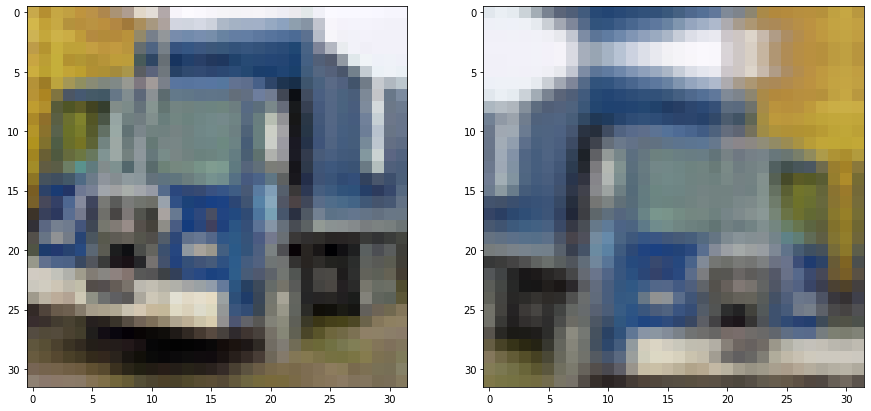

In [8]:
idx = 14
f, axarr = plt.subplots(1, 2, figsize=(15, 15))
axarr[0].imshow(X_test[idx])
axarr[1].imshow(aug(X_test[idx:idx+1], training=True)[0])

In [9]:
mainLR = 0.001
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=mainLR)
autoencoder.compile(optimizer, loss_fn)

train_acc_metric = tf.keras.metrics.MeanSquaredError()
val_acc_metric = tf.keras.metrics.MeanSquaredError()

In [10]:
prediction_history = []

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = autoencoder(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, autoencoder.trainable_weights)
    optimizer.apply_gradients(zip(grads, autoencoder.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = autoencoder(x, training=False)
    val_acc_metric.update_state(y, val_logits)
    
epochs = 100
batchSize = 256
steps = math.ceil(numTrain / batchSize)
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()
    #self.model.layers[2].stddev = random.randint(0, maxNoise) * 0.001
    #X_train = np.random.shuffle(X_train)

    for step in range(steps):
        idxLow = step * batchSize
        idxHigh = idxLow + batchSize
        if idxHigh > numTrain:
            idxHigh = None
        if step == 0:
            idxLow = None
        X_step = np.copy(aug(X_train[idxLow:idxHigh], training=True).numpy())
        #X_steps.append(X_step)
        loss_value = train_step(X_step, X_step)

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.6f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    test_step(X_valid, X_valid)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    
    if val_acc < 0.005:
        tf.keras.backend.set_value(autoencoder.optimizer.lr, mainLR * 0.01)
    elif val_acc < 0.010:
        tf.keras.backend.set_value(autoencoder.optimizer.lr, mainLR * 0.1)
    elif val_acc < 0.015:
        tf.keras.backend.set_value(autoencoder.optimizer.lr, mainLR * 0.5)
        
    prediction_history.append(autoencoder(X_test[0:1]))
    
    print("Validation acc:          %.6f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training acc over epoch: 0.064883
Validation acc:          0.064463
Time taken: 11.58s

Start of epoch 1
Training acc over epoch: 0.018521
Validation acc:          0.047704
Time taken: 9.40s

Start of epoch 2
Training acc over epoch: 0.013510
Validation acc:          0.025423
Time taken: 9.20s

Start of epoch 3
Training acc over epoch: 0.010951
Validation acc:          0.020838
Time taken: 8.88s

Start of epoch 4
Training acc over epoch: 0.009565
Validation acc:          0.019755
Time taken: 8.77s

Start of epoch 5
Training acc over epoch: 0.008752
Validation acc:          0.016800
Time taken: 8.80s

Start of epoch 6
Training acc over epoch: 0.008096
Validation acc:          0.013816
Time taken: 8.72s

Start of epoch 7
Training acc over epoch: 0.007530
Validation acc:          0.011534
Time taken: 8.78s

Start of epoch 8
Training acc over epoch: 0.007328
Validation acc:          0.010954
Time taken: 9.07s

Start of epoch 9
Training acc over epoch: 0.007143
Validation 

Training acc over epoch: 0.005017
Validation acc:          0.008162
Time taken: 9.61s

Start of epoch 79
Training acc over epoch: 0.005003
Validation acc:          0.008114
Time taken: 9.73s

Start of epoch 80
Training acc over epoch: 0.004984
Validation acc:          0.008101
Time taken: 9.62s

Start of epoch 81
Training acc over epoch: 0.004972
Validation acc:          0.008227
Time taken: 9.26s

Start of epoch 82
Training acc over epoch: 0.004979
Validation acc:          0.008262
Time taken: 8.84s

Start of epoch 83
Training acc over epoch: 0.004956
Validation acc:          0.008273
Time taken: 9.09s

Start of epoch 84
Training acc over epoch: 0.004958
Validation acc:          0.008140
Time taken: 9.67s

Start of epoch 85
Training acc over epoch: 0.004939
Validation acc:          0.008118
Time taken: 9.61s

Start of epoch 86
Training acc over epoch: 0.004939
Validation acc:          0.008117
Time taken: 9.69s

Start of epoch 87
Training acc over epoch: 0.005021
Validation acc:      

## One Number Training Progression Grid

In [12]:
idx = 0
prediction_history = np.array(prediction_history)
print(prediction_history.shape)

(100, 1, 32, 32, 3)


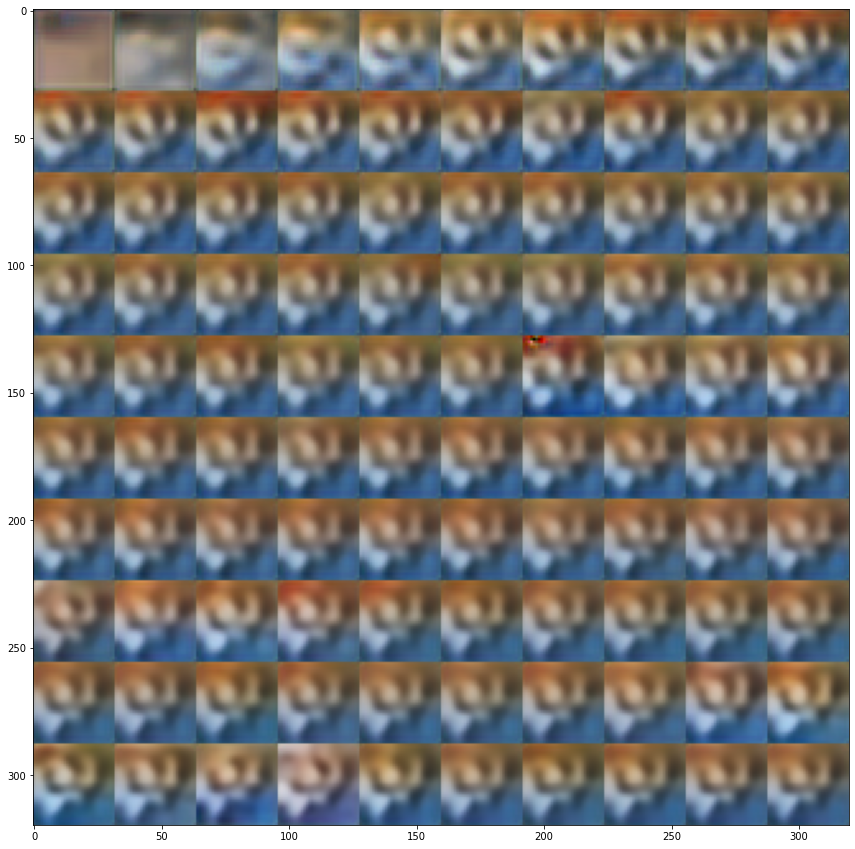

In [14]:
idx = 0
splits = 10
mult = 1
f, axarr = plt.subplots(1, 1, figsize=(15, 15))
blends = np.zeros(shape=(32 * splits, 32 * splits, 3))
other = np.zeros(shape=(32 * splits, 32 * splits, 3))
for i in range(splits):
    for j in range(splits):
        this_img = prediction_history[mult * (i*splits + j)][idx]
        blends[i*32:(i+1)*32, j*32:(j+1)*32] = this_img
        other[i*32:(i+1)*32, j*32:(j+1)*32] = prediction_history[mult * (i*splits + j)][idx]

axarr.imshow(other)
        

## Compare Orig to Result

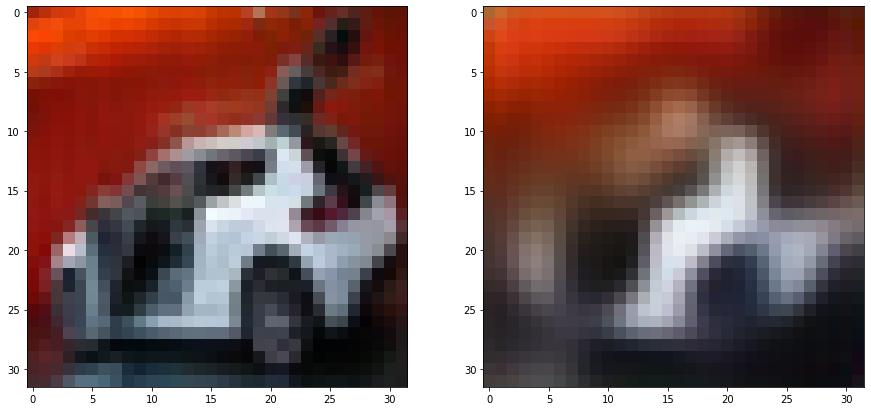

In [15]:
idx = 6
f, axarr = plt.subplots(1, 2, figsize=(15, 15))
axarr[0].imshow(X_test[idx])
axarr[1].imshow(autoencoder(X_test[idx:idx+1])[0])

## HTML5 Video (does not animate in GitHub though)

In [16]:
from matplotlib import animation
from IPython.display import HTML
from PIL import Image, ImageSequence

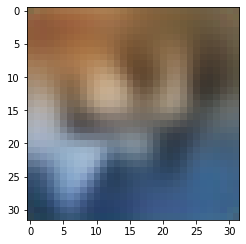

In [17]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

idx = 0
prediction_history = predHistory

def update(i):
    frame = prediction_history[i][idx]
    ax.imshow(frame)
    ax.set_axis_off()

anim = animation.FuncAnimation(fig, update, frames=100, interval=50)
ax.imshow(prediction_history[-1][idx])

In [18]:
HTML(anim.to_html5_video())

## GIF MAKER

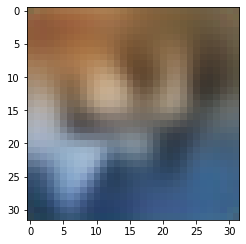

In [27]:
# https://github.com/python-pillow/Pillow/issues/4544
idx = 0
pred_numpy_array = np.array(prediction_history)
pred_numpy_array *= 255
pred_numpy_array = pred_numpy_array.astype(np.uint8)
plt.imshow(pred_numpy_array[99][idx])

ims = [Image.fromarray(pred_numpy_array[i][idx]) for i in range(100)]

ims[0].save('single_digit.gif', save_all=True, append_images=ims[1:], loop=0, duration=50)


In [28]:
# https://github.com/ipython/ipython/issues/10045#issuecomment-318202267
HTML('<img src="single_digit.gif" style="width:360px;heigh:360px;">')

## MP4

In [29]:
pred_numpy_array = np.array(prediction_history)

In [30]:
import cv2

output = 'tiled_video.mp4'

# https://github.com/python-pillow/Pillow/issues/4544
idx = 0
pred_numpy_array = np.array(prediction_history)
pred_numpy_array *= 255
pred_numpy_array = pred_numpy_array.astype(np.uint8)

#images = [Image.fromarray(pred_numpy_array[i][idx][:,:,0]) for i in range(100)]
images = [pred_numpy_array[i][idx][:,:,0] for i in range(100)]

This will take some time


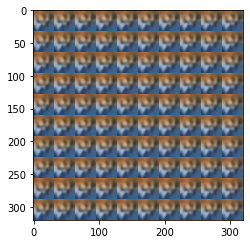

In [36]:
tiles = 10
totalFrames = 100

blends = np.zeros(shape=(totalFrames, 32 * tiles, 32 * tiles, 3)).astype(np.uint8)
for frameNum in range(totalFrames):
    for i in range(tiles):
        for j in range(tiles):
            this_img = pred_numpy_array[frameNum][0]
            blends[frameNum, i*32:(i+1)*32, j*32:(j+1)*32, :] = this_img

plt.imshow(blends[-1])
    
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output, fourcc, 30, (tiles*32, tiles*32))
print('This will take some time')
for i, blend in enumerate(blends):
    out.write(cv2.applyColorMap(blend, cv2.COLORMAP_JET))
            

out.release()

plt.imshow(blend)

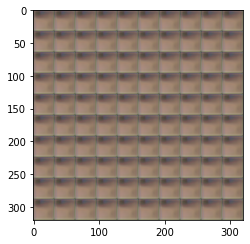

In [37]:
plt.imshow(blends[0])